In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

#emcee
import emcee
import corner as corner
import time

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, binned_statistic_2d

### TQDM
from tqdm import tqdm_notebook

In [2]:
def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

# PARSEC

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# APOKASC

In [4]:
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')
dr16 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r12-l33.fits.gz')
apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

<ipython-input-4-c45f30211bba>:4: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)


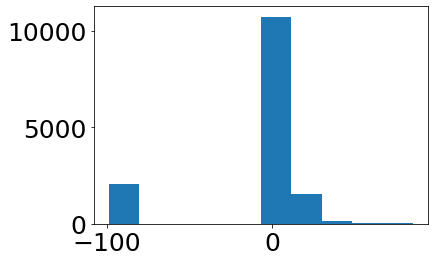

<ipython-input-259-8eac54b74ee3>:31: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


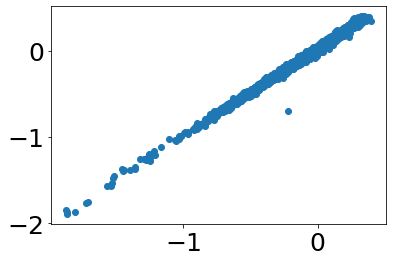

In [259]:
from astropy.io import ascii

kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')
# dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')

# xmatch APOKASC Catalogs
_, k672idx, k3idx = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)
k672 = kasc672[k672idx]
k3 = kasc3[k3idx]

# xmatch APOKASC with DR17
_, k3idx, dr17idx = np.intersect1d(k3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

k672dr17 = k672[k3idx]
k3dr17 = k3[k3idx]
kdr17 = dr17[dr17idx]

plt.hist(k3dr17['IntAge'])
plt.show()

# Select RGB stars
ageevs = np.where((k3dr17['IntAge']>-10.)&(k672dr17['APOKASC3_CONS_EVSTATES']==1.0))#&
#                   (kdr17['GAIAEDR3_PARALLAX']/kdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

k672dr17 = k672dr17[ageevs]
k3dr17 = k3dr17[ageevs]
kdr17 = kdr17[ageevs]

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

plt.scatter(kdr17['FE_H'],k3dr17['Fe/H'])

# xmatch dr16
_, k3dr16_idx, dr16_idx = np.intersect1d(k3dr17['2MASSID'],dr16['APOGEE_ID'],return_indices=True)

k672dr16 = k672dr17[k3dr16_idx]
k3dr16 = k3dr17[k3dr16_idx]
kdr17_16 = kdr17[k3dr16_idx]

kdr16 = dr16[dr16_idx]

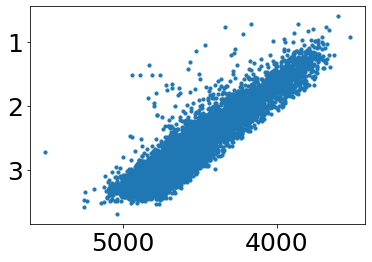

In [8]:
plt.scatter(kdr17['FPARAM'][:,0],kdr17['FPARAM'][:,1],s=10)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# Gaia EDR3

In [6]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

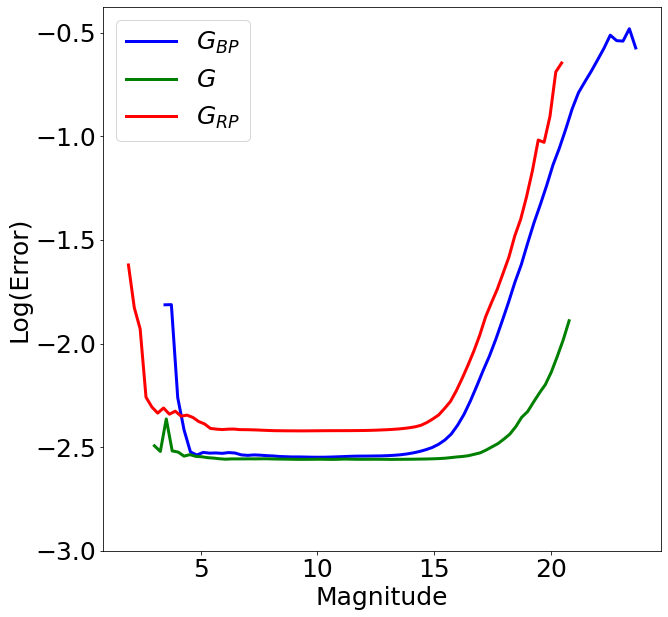

In [7]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = IUS(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(kdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

In [ ]:
one panel with resid vs logg and best line fit
second panel resid vs [M/H] with applied logg corr best fit quad in feh
third final resid plot vs logg print final rmse

use logg and teff find iso point 

# Calculate the shift in FPARAM logg as a function of uncalibrated logg

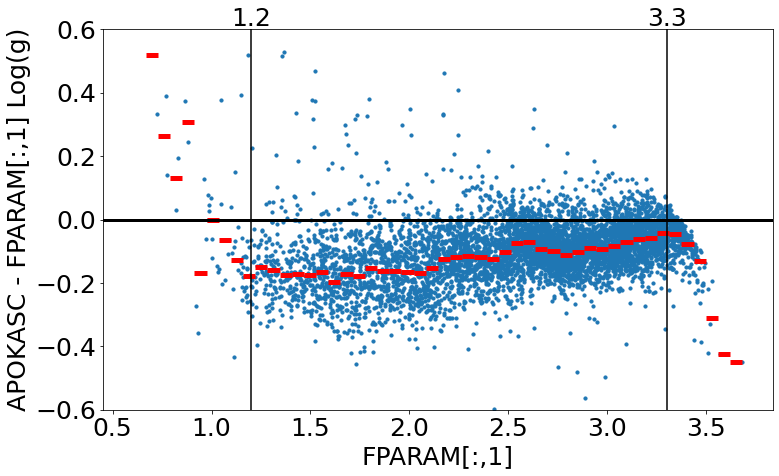

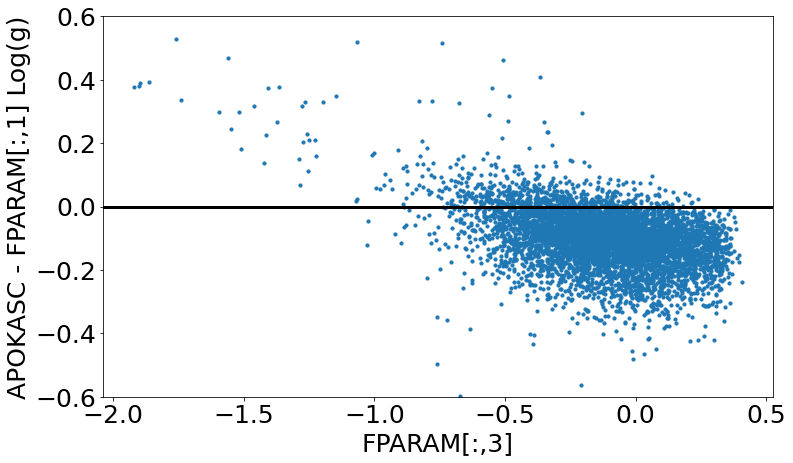

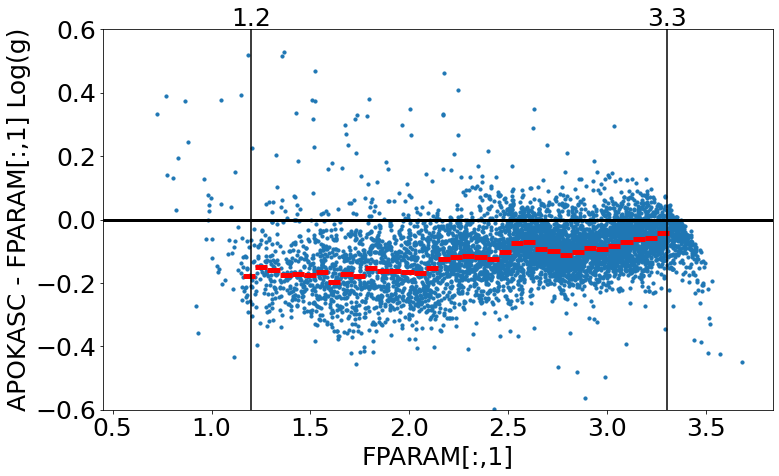

In [250]:
finloggcut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True))

loggmeds,loggedgs,loggnums = binned_statistic(kdr17['FPARAM'][:,1][finloggcut],
                                              (k3dr17['Logg']-kdr17['FPARAM'][:,1])[finloggcut],
                                              statistic='median',bins=50)

loggmads = 999999.0*np.ones(len(np.unique(loggnums)))
for i in range(50):
    loggmads[i] = mad((k3dr17['Logg']-kdr17['FPARAM'][:,1])[finloggcut]
                      [np.where(loggnums==np.unique(loggnums)[i])])
    
loggcens = loggedgs[:-1]+np.median(np.diff(loggedgs))/2.

### Plot
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],s=10)
plt.axhline(0.0,c='k',lw=3.0)

plt.hlines(loggmeds,loggedgs[:-1],loggedgs[1:],colors='red',lw=5.)

plt.axvline(1.2,c='k')
plt.axvline(3.3,c='k')

plt.text(1.2-0.1,0.61,'1.2')
plt.text(3.3-0.1,0.61,'3.3')

plt.ylim(-0.6,0.6)

plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'APOKASC - FPARAM[:,1] Log(g)')
plt.savefig('../plots/loggresids_logg.pdf',dpi=300,bbox_inches='tight')
plt.show()

### Plot
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,3],k3dr17['Logg']-kdr17['FPARAM'][:,1],s=10)
plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.6,0.6)

plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'APOKASC - FPARAM[:,1] Log(g)')
plt.savefig('../plots/loggresids_mh.pdf',dpi=300,bbox_inches='tight')
plt.show()

### Plot
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],s=10)
plt.axhline(0.0,c='k',lw=3.0)

logg_left = 9
logg_right = -6
plt.hlines(loggmeds[logg_left:logg_right],loggedgs[:-1][logg_left:logg_right],loggedgs[1:][logg_left:logg_right],
           colors='red',lw=5.)

plt.axvline(1.2,c='k')
plt.axvline(3.3,c='k')

plt.text(1.2-0.1,0.61,'1.2')
plt.text(3.3-0.1,0.61,'3.3')

plt.ylim(-0.6,0.6)

plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'APOKASC - FPARAM[:,1] Log(g)')
plt.show()

In [251]:
# Fit Line to Binned Data

loggbinfin = np.where((np.isfinite(loggcens[logg_left:logg_right])==True)&
                      (np.isfinite(loggmeds[logg_left:logg_right])==True)&
                      (loggmads[logg_left:logg_right]>0.))
logg_logg_correction = np.poly1d(np.polyfit(loggcens[logg_left:logg_right][loggbinfin],
                                            loggmeds[logg_left:logg_right][loggbinfin],1,
                                            w=np.reciprocal(np.square(loggmads[logg_left:logg_right]))))

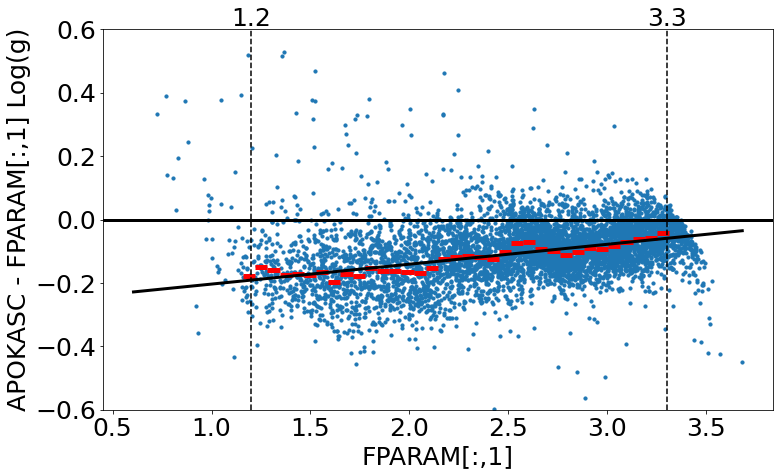

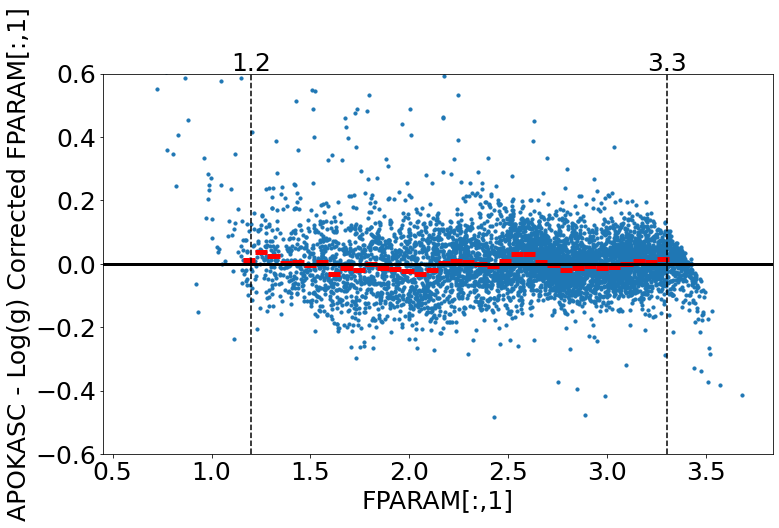

In [254]:
### Best fit line Plot
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],s=10)
plt.axhline(0.0,c='k',lw=3.0)

logg_left = 9
logg_right = -6
plt.hlines(meds[logg_left:logg_right],edgs[:-1][logg_left:logg_right],edgs[1:][logg_left:logg_right],
           colors='red',lw=5.)

xs_fparam1 = np.linspace(np.nanmin(kdr17['FPARAM'][:,1]),np.nanmax(kdr17['FPARAM'][:,1]))
plt.plot(xs_fparam1,logg_logg_correction(xs_fparam1),c='k',lw=3.0)

plt.axvline(1.2,c='k',ls='--')
plt.axvline(3.3,c='k',ls='--')

plt.text(1.2-0.1,0.61,'1.2')
plt.text(3.3-0.1,0.61,'3.3')

plt.ylim(-0.6,0.6)

plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'APOKASC - FPARAM[:,1] Log(g)')
plt.savefig('../plots/loggresids_logg_trend.pdf',dpi=300,bbox_inches='tight')
plt.show()

### Corrected Logg Plot
finloggcut2 = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True)&
                       (np.isfinite(logg_logg_correction(kdr17['FPARAM'][:,1]))==True))

loggmeds2,loggedgs2,loggnums2 = binned_statistic(kdr17['FPARAM'][:,1][finloggcut2],
                                                 (k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_correction(kdr17['FPARAM'][:,1])))[fincut2],
                                                 statistic='median',bins=50)

loggmads2 = 999999.0*np.ones(len(np.unique(loggnums2)))
for i in range(50):
    loggmads2[i] = mad((k3dr17['Logg']-kdr17['FPARAM'][:,1])[finloggcut2]
                      [np.where(loggnums2==np.unique(loggnums2)[i])])
    
loggcens2 = loggedgs2[:-1]+np.median(np.diff(loggedgs2))/2.


plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],
            k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_correction(kdr17['FPARAM'][:,1])),s=10)
plt.axhline(0.0,c='k',lw=3.0)

logg_left = 9
logg_right = -6
plt.hlines(loggmeds2[logg_left:logg_right],loggedgs2[:-1][logg_left:logg_right],
           loggedgs2[1:][logg_left:logg_right],colors='red',lw=5.)

plt.axvline(1.2,c='k',ls='--')
plt.axvline(3.3,c='k',ls='--')

plt.text(1.2-0.1,0.61,'1.2')
plt.text(3.3-0.1,0.61,'3.3')

plt.ylim(-0.6,0.6)

plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'APOKASC - Log(g) Corrected FPARAM[:,1]')
plt.savefig('../plots/corrloggresids_logg.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Calculate the shift in the Logg corrected FPARAM logg as a function of uncalibrated [M/H]

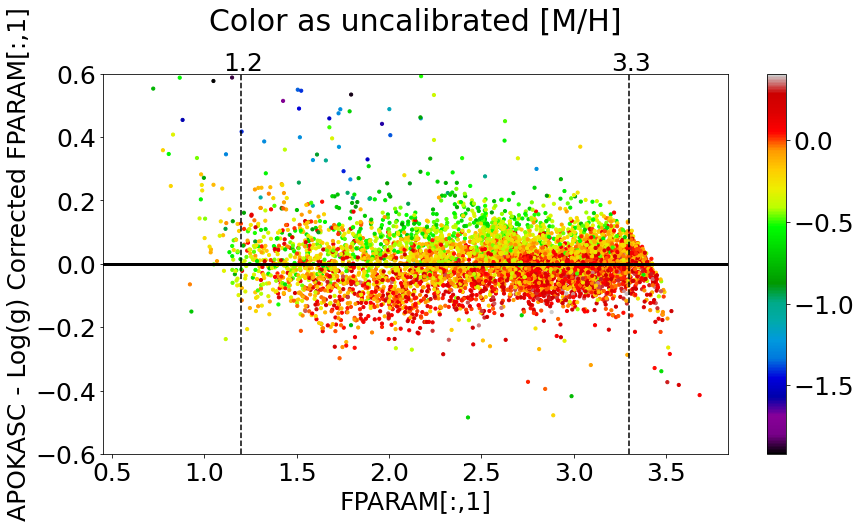

In [261]:
### Corrected Logg Plot
finloggcut2 = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True)&
                       (np.isfinite(logg_logg_correction(kdr17['FPARAM'][:,1]))==True))

loggmeds2,loggedgs2,loggnums2 = binned_statistic(kdr17['FPARAM'][:,1][finloggcut2],
                                                 (k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_correction(kdr17['FPARAM'][:,1])))[fincut2],
                                                 statistic='median',bins=50)

loggmads2 = 999999.0*np.ones(len(np.unique(loggnums2)))
for i in range(50):
    loggmads2[i] = mad((k3dr17['Logg']-kdr17['FPARAM'][:,1])[finloggcut2]
                      [np.where(loggnums2==np.unique(loggnums2)[i])])
    
loggcens2 = loggedgs2[:-1]+np.median(np.diff(loggedgs2))/2.

plt.figure(figsize=[14,7])
plt.scatter(kdr17['FPARAM'][:,1],
            k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_correction(kdr17['FPARAM'][:,1])),
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)
plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.axvline(1.2,c='k',ls='--')
plt.axvline(3.3,c='k',ls='--')

plt.text(1.2-0.1,0.61,'1.2')
plt.text(3.3-0.1,0.61,'3.3')

plt.ylim(-0.6,0.6)

plt.title(r'Color as uncalibrated [M/H]',y=1.1)
plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'APOKASC - Log(g) Corrected FPARAM[:,1]')
plt.savefig('../plots/corrloggresids_colormh.pdf',dpi=300,bbox_inches='tight')
plt.show()

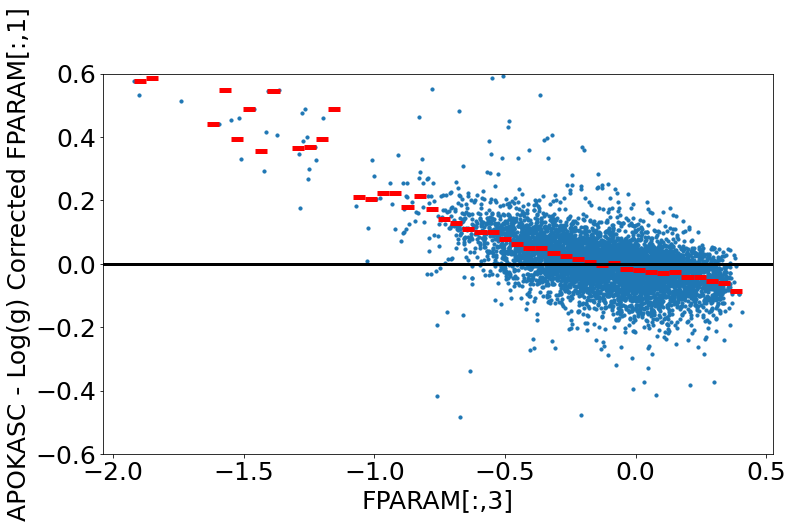

In [166]:
finmhcut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True)&
                    (np.isfinite(kdr17['FPARAM'][:,3])==True))

mhmeds,mhedgs,mhnums = binned_statistic(kdr17['FPARAM'][:,3][finmhcut],
                                        (k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_correction(kdr17['FPARAM'][:,1])))[finmhcut],
                                              statistic='median',bins=50)

mhcens = mhedgs[:-1]+np.median(np.diff(mhedgs))/2.

mhbinfin = np.where((np.isfinite(mhmeds)==True)&(np.isfinite(mhcens)==True))

mhmads = 999999.0*np.ones(len(np.unique(mhnums)))
for i in range(len(np.unique(mhnums))):
    mhmads[i] = mad((k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_correction(kdr17['FPARAM'][:,1])))[finmhcut]
                      [np.where(mhnums==np.unique(mhnums)[i])])
    
mhmads_cut = np.where(mhmads>0.)

### Corrected mh Plot [M/H]
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,3][finmhcut],
            (k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_correction(kdr17['FPARAM'][:,1])))[finmhcut],s=10)
# plt.colorbar()

plt.hlines(mhmeds,mhedgs[:-1],mhedgs[1:],colors='red',lw=5.)

plt.axhline(0.0,c='k',lw=3.0)

# plt.axvline(1.2,c='k',ls='--')
# plt.axvline(3.3,c='k',ls='--')

# plt.text(1.2-0.1,0.61,'1.2')
# plt.text(3.3-0.1,0.61,'3.3')

plt.ylim(-0.6,0.6)

plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'APOKASC - Log(g) Corrected FPARAM[:,1]')
plt.savefig('../plots/corrloggresids_mh.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [184]:
# Fit Function to Binned Data

logg_mh_correction = np.poly1d(np.polyfit(mhcens[mhbinfin][mhmads_cut],mhmeds[mhbinfin][mhmads_cut],2,
                                          w=np.reciprocal(np.square(mhmads[mhmads_cut]))))

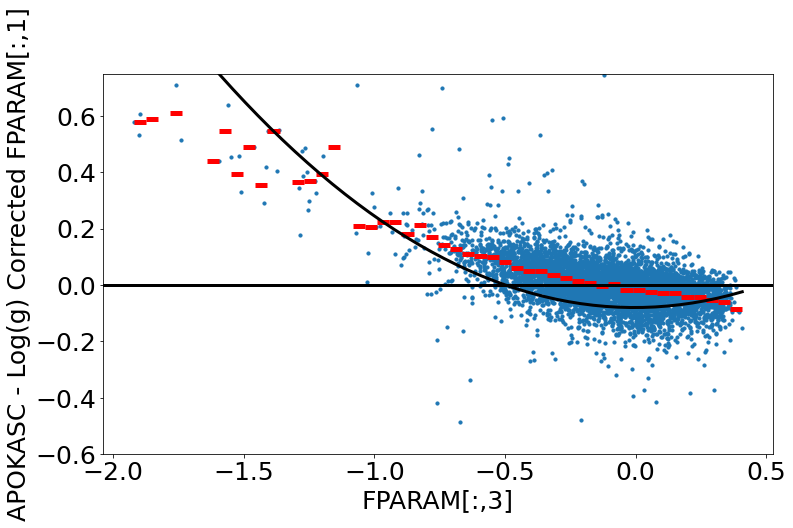

In [202]:
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,3][finmhcut],
            (k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_correction(kdr17['FPARAM'][:,1])))[finmhcut],s=10)

plt.hlines(mhmeds,mhedgs[:-1],mhedgs[1:],colors='red',lw=5.)

xs_fparam3 = np.linspace(np.nanmin(kdr17['FPARAM'][:,3][finmhcut]),np.nanmax(kdr17['FPARAM'][:,3][finmhcut]))
plt.plot(xs_fparam3,logg_mh_correction(xs_fparam3),c='k',lw=3.0)

plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.6,0.75)

plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'APOKASC - Log(g) Corrected FPARAM[:,1]')
plt.show()

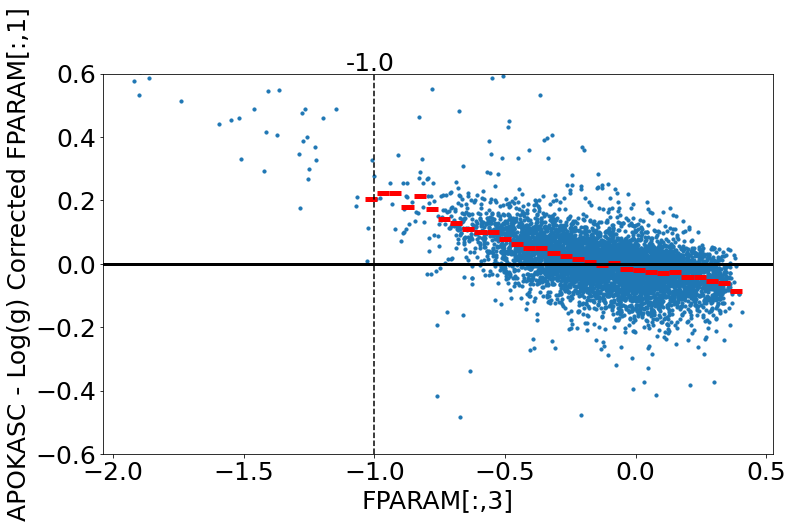

In [200]:
### Corrected mh Plot [M/H]
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,3][finmhcut],
            (k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_correction(kdr17['FPARAM'][:,1])))[finmhcut],s=10)

mh_left = 19
plt.hlines(mhmeds[mh_left:],mhedgs[:-1][mh_left:],mhedgs[1:][mh_left:],colors='red',lw=5.)

plt.axhline(0.0,c='k',lw=3.0)

plt.axvline(-1.0,c='k',ls='--')
plt.text(-1.0-0.11,0.61,'-1.0')

plt.ylim(-0.6,0.6)

plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'APOKASC - Log(g) Corrected FPARAM[:,1]')
plt.show()

In [245]:
logg_mh_correction2 = np.poly1d(np.polyfit(mhcens[mhbinfin][mhmads_cut][mh_left:],
                                           mhmeds[mhbinfin][mhmads_cut][mh_left:],2,
                                           w=np.reciprocal(np.square(mhmads[mhmads_cut][mh_left:]))))

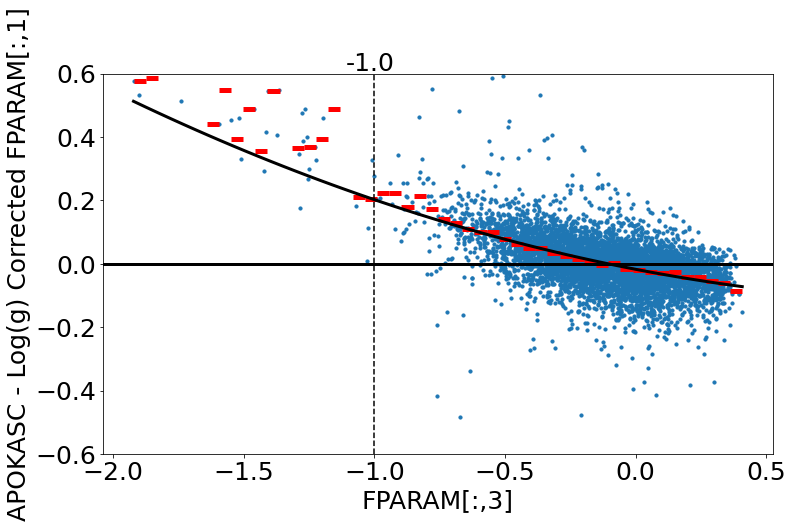

In [256]:
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,3][finmhcut],
            (k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_correction(kdr17['FPARAM'][:,1])))[finmhcut],s=10)

plt.hlines(mhmeds,mhedgs[:-1],mhedgs[1:],colors='red',lw=5.)

xs_fparam3 = np.linspace(np.nanmin(kdr17['FPARAM'][:,3][finmhcut]),np.nanmax(kdr17['FPARAM'][:,3][finmhcut]))
plt.plot(xs_fparam3,logg_mh_correction2(xs_fparam3),c='k',lw=3.0)

plt.axhline(0.0,c='k',lw=3.0)

plt.axvline(-1.0,c='k',ls='--')
plt.text(-1.0-0.11,0.61,'-1.0')

plt.ylim(-0.6,0.6)

plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'APOKASC - Log(g) Corrected FPARAM[:,1]')
plt.savefig('../plots/corrloggresids_mh_trend.pdf',dpi=300,bbox_inches='tight')
plt.show()

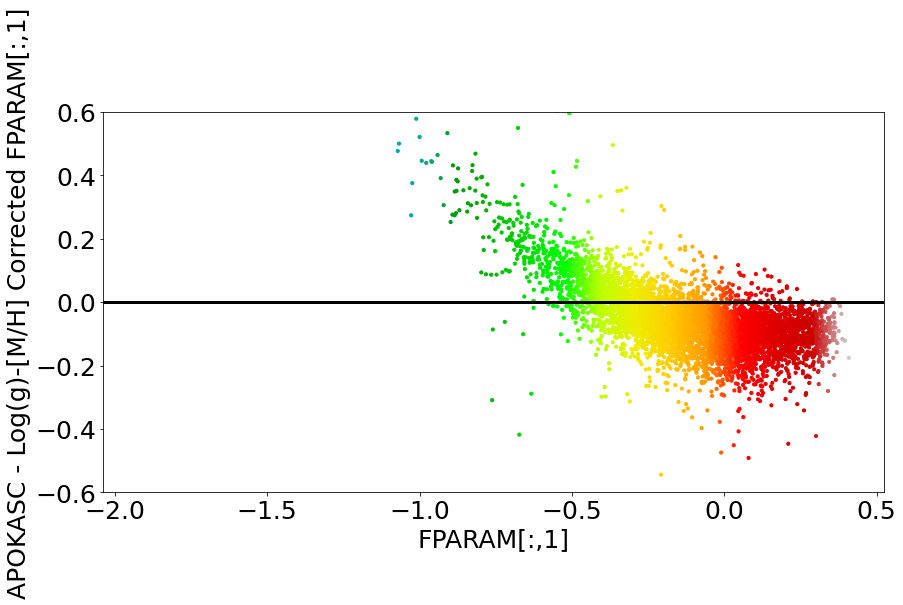

In [243]:
### Corrected mh Plot
plt.figure(figsize=[14,7])
plt.scatter(kdr17['FPARAM'][:,3],
            k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_correction(kdr17['FPARAM'][:,1])-
                            logg_mh_correction(kdr17['FPARAM'][:,3])),
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)

# plt.hlines(mhmeds2,mhedgs2[:-1],mhedgs2[1:],colors='red',lw=5.)

plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.6,0.6)

plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'APOKASC - Log(g)-[M/H] Corrected FPARAM[:,1]')
plt.show()

In [68]:
# # fit line to binned Data

# endcut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True)&
#                   (kdr17['FPARAM'][:,1]>1.2)&(kdr17['FPARAM'][:,1]<3.3))

# meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][endcut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[endcut],bins=50)
# cens = edgs[:-1]+np.median(np.diff(edgs))/2

# fincut2 = np.where((np.isfinite(meds)==True)&(np.isfinite(cens)==True))

# logg_logg_corr = np.poly1d(np.polyfit(cens[fincut2],meds[fincut2],1))

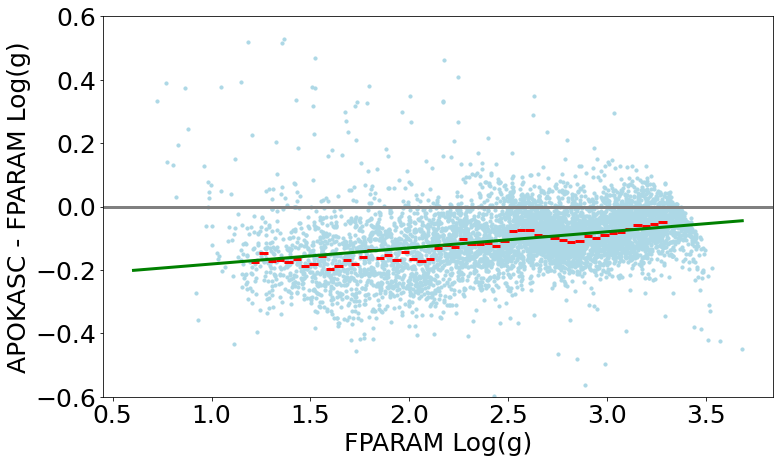

In [69]:
meds2,edgs2,_ = binned_statistic(kdr17['FPARAM'][:,1][endcut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[endcut],
                                 statistic='median',bins=50)

plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],s=10,c='lightblue')

plt.hlines(meds2,edgs2[:-1],edgs2[1:],colors='red',lw=3.)

xs_fparam1 = np.linspace(min(kdr17['FPARAM'][:,1]),max(kdr17['FPARAM'][:,1]))

plt.plot(xs_fparam1,logg_logg_corr(xs_fparam1),c='green',lw=3.0)

plt.axhline(0.0,c='grey',lw=3.0)

plt.ylim(-0.6,0.6)

plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC - FPARAM Log(g)')
plt.show()

# plt.figure(figsize=[12,7])
# plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],s=10)
# plt.axhline(0.0,c='k',lw=3.0)

# meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],
#                                statistic='median',bins=50)
# plt.hlines(meds,edgs[:-1],edgs[1:],colors='red',lw=5.)

# plt.plot(xs_fparam1,logg_logg_corr(xs_fparam1),c='green',lw=3.0)

# plt.axvline(1.2,c='k')
# plt.axvline(3.3,c='k')

# plt.ylim(-0.6,0.6)

# plt.xlabel(r'FPARAM Log(g)')
# plt.ylabel(r'APOKASC - FPARAM Log(g)')
# plt.show()

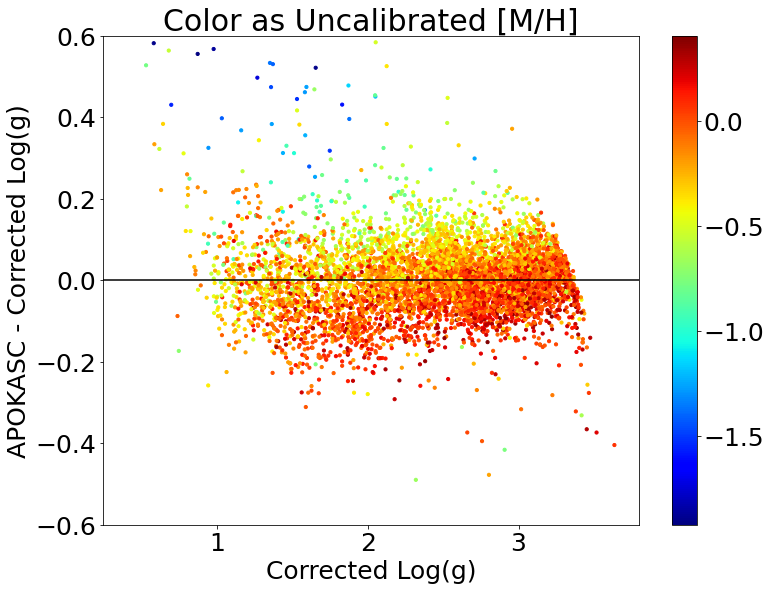

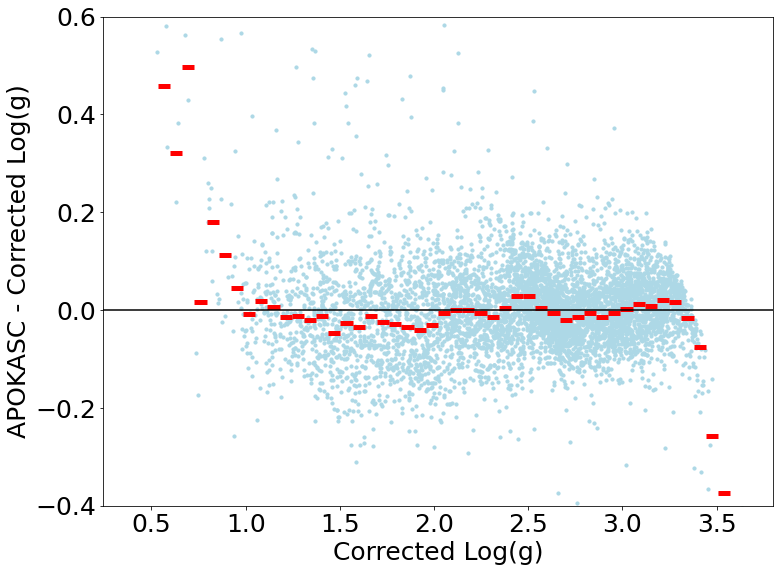

In [262]:
plt.figure(figsize=[12,9])
plt.scatter(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1]),
            k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1])),
            c=kdr17['FPARAM'][:,3],cmap='jet',s=10)
plt.colorbar()
plt.ylim(-0.6,0.6)
plt.axhline(0.0,c='k')

plt.title(r'Color as Uncalibrated [M/H]')
plt.xlabel(r'Corrected Log(g)')
plt.ylabel(r'APOKASC - Corrected Log(g)')
plt.show()

###
plt.figure(figsize=[12,9])
plt.scatter(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1]),
            k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1])),
            c='lightblue',s=10)

plt.ylim(-0.4,0.6)
plt.axhline(0.0,c='k')

fincut2 = np.where((np.isfinite(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1]))==True)&
                   (np.isfinite(k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1])))==True))
meds,edgs,_ = binned_statistic((kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1]))[fincut2],
                               (k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1])))[fincut2],statistic='median',bins=50)
plt.hlines(meds,edgs[:-1],edgs[1:],colors='red',lw=5.)

plt.xlabel(r'Corrected Log(g)')
plt.ylabel(r'APOKASC - Corrected Log(g)')
plt.show()

# Calculate the shift in the logg corrected FPARAM logg as a function of FPARAM [M/H]

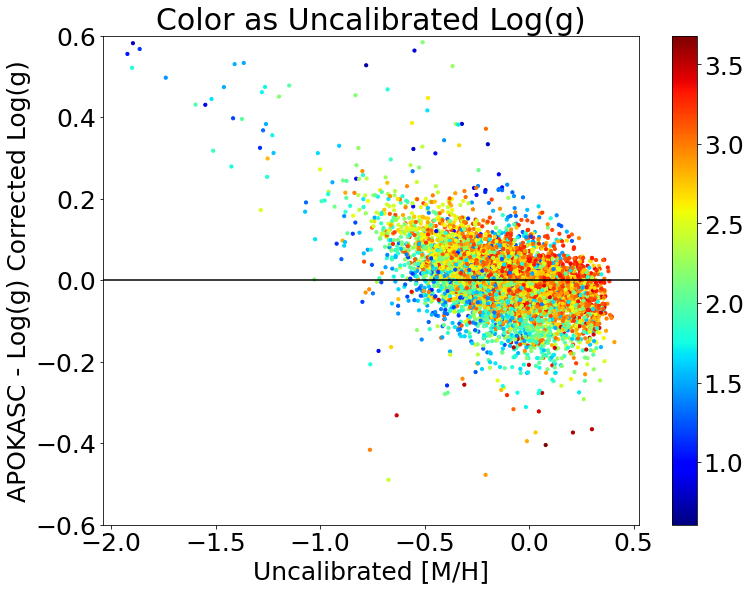

In [29]:
plt.figure(figsize=[12,9])
plt.scatter(kdr17['FPARAM'][:,3],k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1])),
            c=kdr17['FPARAM'][:,1],cmap='jet',s=10)
plt.colorbar()
plt.ylim(-0.6,0.6)
plt.axhline(0.0,c='k')

plt.title(r'Color as Uncalibrated Log(g)')
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'APOKASC - Log(g) Corrected Log(g)')
plt.show()

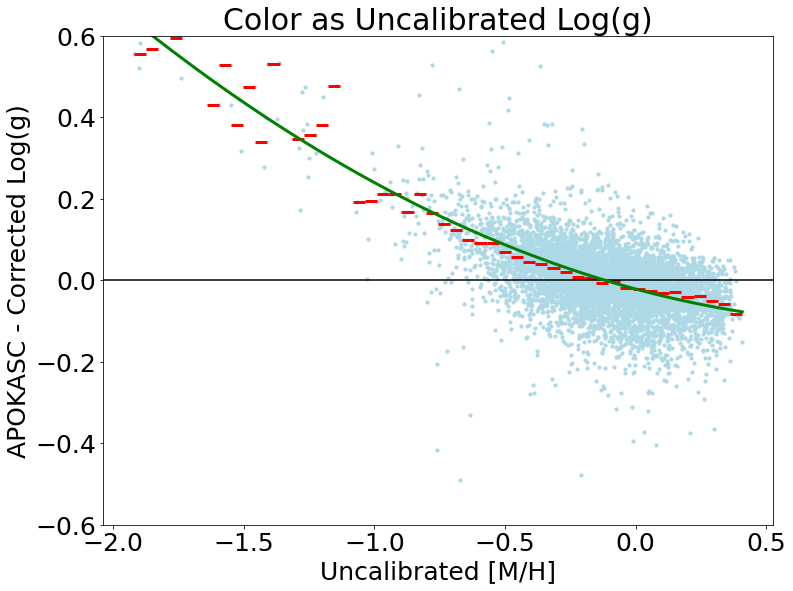

In [63]:
endcut2 = np.where((np.isfinite(kdr17['FPARAM'][:,3])==True)&
                  (np.isfinite(k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1])))==True))#&
#                   (kdr17['FPARAM'][:,3]>-1.))
meds,edgs,num = binned_statistic(kdr17['FPARAM'][:,3][endcut2],
                                 (k3dr17['Logg']-(kdr17['FPARAM'][:,1]+
                                                  logg_logg_corr(kdr17['FPARAM'][:,1])))[endcut2],
                                 statistic='median',bins=50)
# mads,_,_ = binned_statistic(kdr17['FPARAM'][:,3][endcut2],
#                                  (k3dr17['Logg']-(kdr17['FPARAM'][:,1]+
#                                                   logg_logg_corr(kdr17['FPARAM'][:,1])))[endcut2],bins=50)

cens = edgs[:-1]+np.median(np.diff(edgs))/2


plt.figure(figsize=[12,9])

plt.hlines(meds,edgs[:-1],edgs[1:],colors='red',lw=3.)

plt.scatter(kdr17['FPARAM'][:,3],k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1])),
            s=10,c='lightblue')
plt.ylim(-0.6,0.6)
plt.axhline(0.0,c='k')

plt.title(r'Color as Uncalibrated Log(g)')
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'APOKASC - Corrected Log(g)')

fincut = np.where((np.isfinite(meds)==True)&(np.isfinite(cens)==True))#&(mads>0.))
logg_feh_corr = np.poly1d(np.polyfit(cens[fincut],meds[fincut],2))

xs_fparam3 = np.linspace(min(kdr17['FPARAM'][:,3]),max(kdr17['FPARAM'][:,3]))
plt.plot(xs_fparam3,logg_feh_corr(xs_fparam3),c='green',lw=3.0)

plt.show()

In [57]:
mads = 999999.0*np.ones(len(np.unique(num)))
for i in range(len(np.unique(num))):
    mads[i] = mad(((kdr17['FPARAM'][:,1]+
                    logg_logg_corr(kdr17['FPARAM'][:,1]))[endcut2])[np.where(num==np.unique(num)[i])])

mads

array([0.29155695, 0.        , 0.03215694, 0.        , 0.33713371,
       0.10866129, 0.        , 0.28993857, 0.01954651, 0.320099  ,
       0.05706298, 0.3067528 , 0.        , 0.12841785, 0.24800837,
       0.02952981, 0.26025119, 0.17907047, 0.27906168, 0.60656953,
       0.3618716 , 0.34080136, 0.44730818, 0.36581236, 0.42855   ,
       0.47962308, 0.42791939, 0.38567424, 0.35635448, 0.40574598,
       0.38756573, 0.43711472, 0.4330163 , 0.39502692, 0.40637636,
       0.38882637, 0.34920835, 0.34011829, 0.3448472 , 0.29267073,
       0.34668636, 0.30223393, 0.3229363 , 0.2696569 , 0.16404283])

In [58]:
meds

array([ 5.52414112e-01,  5.67022113e-01,             nan,  5.93600322e-01,
                   nan,             nan,  4.30625542e-01,  5.27090795e-01,
        3.80956071e-01,  4.73537146e-01,  3.37967837e-01,  4.86045215e-01,
                   nan,  3.31313129e-01,  3.52826657e-01,  3.81147884e-01,
        4.77495628e-01,             nan,  3.49536926e-01,  1.75809713e-01,
        2.07737197e-01,  4.78846926e-01,  1.63819414e-01,  2.23580777e-01,
        1.41031602e-01,  8.92840322e-02,  1.22194014e-01,  8.27982079e-02,
        9.52761192e-02,  9.54925147e-02,  9.21562862e-02,  5.86454188e-02,
        3.76216912e-02,  4.15862144e-02,  2.85808954e-02,  1.82762729e-02,
        4.56263399e-03, -3.94369476e-05, -5.57699440e-03, -5.70772942e-03,
       -2.22983151e-02, -2.65606353e-02, -3.46067946e-02, -3.14387865e-02,
       -3.31874199e-02, -4.56494498e-02, -4.73963059e-02, -5.80268882e-02,
       -5.89822166e-02, -6.37134498e-02])

In [60]:
np.reciprocal(np.square(mads))

<ipython-input-60-f0ad89ec29c7>:1: RuntimeWarning: divide by zero encountered in reciprocal
  np.reciprocal(np.square(mads))


array([  11.76395055,           inf,  967.05339493,           inf,
          8.7982369 ,   84.693534  ,           inf,   11.89564562,
       2617.348795  ,    9.75958556,  307.10794389,   10.62729965,
                 inf,   60.6386067 ,   16.25800761, 1146.7762661 ,
         14.764357  ,   31.18545177,   12.84102249,    2.71793347,
          7.63644096,    8.60988531,    4.99788564,    7.47279806,
          5.4449888 ,    4.34710223,    5.46104899,    6.72293232,
          7.87472808,    6.07423433,    6.65747063,    5.23370386,
          5.3332447 ,    6.4083557 ,    6.05540401,    6.61437141,
          8.20031902,    8.64450299,    8.40904325,   11.67458437,
          8.32006045,   10.94746463,    9.58884458,   13.75235061,
         37.16083737])